# 🔧 Hanoi Hourly Weather Data Processing - Step 3

## Objective: Clean and Process Hourly Weather Data

**Key Challenges with Hourly Data:**
- **87,698 records** require efficient processing
- **Temporal gaps** need intelligent interpolation
- **Hourly outliers** different from daily outliers
- **Weather transitions** need special handling
- **Memory management** for large dataset

**Processing Pipeline:**
1. Load and validate hourly data structure
2. Handle missing values with time-aware methods
3. Detect and treat hourly-specific outliers
4. Validate temporal sequence integrity
5. Create processed dataset for feature engineering

---

In [2]:
# Import libraries for hourly data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
import os
import sys
from typing import Dict, List, Tuple

warnings.filterwarnings('ignore')

# Add hourly utilities to path
sys.path.append('../src/hourly')
sys.path.append('../src/shared')

try:
    from data_utils_hourly import (
        load_raw_hourly_data, 
        handle_missing_values_hourly,
        detect_hourly_outliers,
        check_hourly_data_quality
    )
    from config import HOURLY_DATA_FILE, HOURLY_PROCESSED_DIR
    print("✅ Successfully imported hourly utilities")
except ImportError as e:
    print(f"⚠️ Import warning: {e}")
    print("📁 Using direct file paths instead")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# File paths
DATA_PATH = '../data/raw/hanoi_weather_data_hourly.csv'
PROCESSED_PATH = '../data/processed/'

print("🔧 HOURLY DATA PROCESSING PIPELINE")
print("=" * 50)
print("✅ Libraries imported successfully!")
print(f"📂 Data source: {DATA_PATH}")
print(f"💾 Output directory: {PROCESSED_PATH}")

✅ Successfully imported hourly utilities
🔧 HOURLY DATA PROCESSING PIPELINE
✅ Libraries imported successfully!
📂 Data source: ../data/raw/hanoi_weather_data_hourly.csv
💾 Output directory: ../data/processed/


## 1️⃣ Load Hourly Dataset

In [5]:
# Load the hourly weather dataset
print("📊 Loading Hanoi hourly weather data...")
df_hourly = pd.read_csv(DATA_PATH)

print(f"✅ Dataset loaded successfully!")
print(f"📏 Shape: {df_hourly.shape}")
print(f"🔢 Records: {df_hourly.shape[0]:,} hours")
print(f"📊 Features: {df_hourly.shape[1]} columns")

# Display basic info
print("\n📋 DATASET OVERVIEW")
print("=" * 30)
print(df_hourly.info())

print("\n📝 FIRST FEW RECORDS")
print("=" * 25)
df_hourly.head()

📊 Loading Hanoi hourly weather data...
✅ Dataset loaded successfully!
📏 Shape: (87696, 28)
🔢 Records: 87,696 hours
📊 Features: 28 columns

📋 DATASET OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87696 entries, 0 to 87695
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              87696 non-null  object 
 1   address           87696 non-null  object 
 2   resolvedAddress   87696 non-null  object 
 3   latitude          87696 non-null  int64  
 4   longitude         87696 non-null  float64
 5   datetime          87696 non-null  object 
 6   temp              87696 non-null  float64
 7   feelslike         87696 non-null  float64
 8   dew               87696 non-null  float64
 9   humidity          87696 non-null  float64
 10  precip            87659 non-null  float64
 11  precipprob        87696 non-null  int64  
 12  preciptype        7503 non-null   object 
 13  snow              87655

,name,address,resolvedAddress,latitude,longitude,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,source
0,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T00:00:00,27.0,31.2,26.0,94.27,0.1,100,rain,0.0,0.0,6.5,5.4,106.6,1007.0,0.0,3.0,0.0,0.0,0.0,NaN,Rain,rain,obs
1,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T01:00:00,26.5,26.5,25.9,96.32,0.0,0,NaN,0.0,0.0,5.8,1.5,344.0,1008.0,1.3,8.9,0.0,0.0,0.0,NaN,Clear,clear-night,obs
2,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T02:00:00,27.0,31.2,26.0,94.27,0.9,100,rain,0.0,0.0,8.3,0.9,20.2,1007.0,44.0,4.5,0.0,0.0,0.0,NaN,"Rain, Partially cloudy",rain,obs
3,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T03:00:00,27.0,31.2,26.0,94.27,0.6,100,rain,0.0,0.0,8.6,0.9,360.0,1007.0,0.0,4.0,0.0,0.0,0.0,NaN,Rain,rain,obs
4,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T04:00:00,26.3,26.3,25.7,96.87,0.0,0,NaN,0.0,0.0,9.7,1.2,12.0,1007.7,0.5,8.6,0.0,0.0,0.0,NaN,Clear,clear-night,obs


## 2️⃣ Datetime Processing & Time Series Setup

In [7]:
# Process datetime for hourly data
print("⏰ Processing datetime information...")

# Check current datetime column
print("📅 Current datetime column info:")
print("Available columns:", list(df_hourly.columns))
datetime_col = 'datetime'  # We know from data inspection it's the 'datetime' column
print(f"Using datetime column: {datetime_col}")
print(f"Sample values:\n{df_hourly[datetime_col].head()}")

# Convert to datetime
df_hourly['datetime_processed'] = pd.to_datetime(df_hourly[datetime_col])

# Extract temporal features for hourly data
df_hourly['date'] = df_hourly['datetime_processed'].dt.date
df_hourly['year'] = df_hourly['datetime_processed'].dt.year
df_hourly['month'] = df_hourly['datetime_processed'].dt.month
df_hourly['day'] = df_hourly['datetime_processed'].dt.day
df_hourly['hour'] = df_hourly['datetime_processed'].dt.hour
df_hourly['day_of_week'] = df_hourly['datetime_processed'].dt.dayofweek
df_hourly['day_of_year'] = df_hourly['datetime_processed'].dt.dayofyear
df_hourly['week_of_year'] = df_hourly['datetime_processed'].dt.isocalendar().week

# Set datetime as index
df_hourly.set_index('datetime_processed', inplace=True)

print("✅ Datetime processing completed!")
print(f"📊 Date range: {df_hourly.index.min()} to {df_hourly.index.max()}")
print(f"⏱️ Total duration: {df_hourly.index.max() - df_hourly.index.min()}")
print(f"🔢 Time frequency: Hourly data")

# Check for time gaps
time_diff = df_hourly.index.to_series().diff()
expected_freq = pd.Timedelta('1H')
gaps = time_diff[time_diff != expected_freq]

if len(gaps) > 0:
    print(f"⚠️ Found {len(gaps)} time gaps in hourly data:")
    print(gaps.head(10))
else:
    print("✅ No time gaps detected - continuous hourly sequence!")

df_hourly.head()

⏰ Processing datetime information...
📅 Current datetime column info:
Available columns: ['name', 'address', 'resolvedAddress', 'latitude', 'longitude', 'datetime', 'temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'conditions', 'icon', 'source']
Using datetime column: datetime
Sample values:
0    2015-09-27T00:00:00
1    2015-09-27T01:00:00
2    2015-09-27T02:00:00
3    2015-09-27T03:00:00
4    2015-09-27T04:00:00
Name: datetime, dtype: object
✅ Datetime processing completed!
📊 Date range: 2015-09-27 00:00:00 to 2025-09-27 23:00:00
⏱️ Total duration: 3653 days 23:00:00
🔢 Time frequency: Hourly data
⚠️ Found 1 time gaps in hourly data:
datetime_processed
2015-09-27   NaT
Name: datetime_processed, dtype: timedelta64[ns]


,name,address,resolvedAddress,latitude,longitude,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,source,date,year,month,day,hour,day_of_week,day_of_year,week_of_year
datetime_processed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-09-27 00:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T00:00:00,27.0,31.2,26.0,94.27,0.1,100,rain,0.0,0.0,6.5,5.4,106.6,1007.0,0.0,3.0,0.0,0.0,0.0,NaN,Rain,rain,obs,2015-09-27,2015,9,27,0,6,270,39
2015-09-27 01:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T01:00:00,26.5,26.5,25.9,96.32,0.0,0,NaN,0.0,0.0,5.8,1.5,344.0,1008.0,1.3,8.9,0.0,0.0,0.0,NaN,Clear,clear-night,obs,2015-09-27,2015,9,27,1,6,270,39
2015-09-27 02:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T02:00:00,27.0,31.2,26.0,94.27,0.9,100,rain,0.0,0.0,8.3,0.9,20.2,1007.0,44.0,4.5,0.0,0.0,0.0,NaN,"Rain, Partially cloudy",rain,obs,2015-09-27,2015,9,27,2,6,270,39
2015-09-27 03:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T03:00:00,27.0,31.2,26.0,94.27,0.6,100,rain,0.0,0.0,8.6,0.9,360.0,1007.0,0.0,4.0,0.0,0.0,0.0,NaN,Rain,rain,obs,2015-09-27,2015,9,27,3,6,270,39
2015-09-27 04:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T04:00:00,26.3,26.3,25.7,96.87,0.0,0,NaN,0.0,0.0,9.7,1.2,12.0,1007.7,0.5,8.6,0.0,0.0,0.0,NaN,Clear,clear-night,obs,2015-09-27,2015,9,27,4,6,270,39


## 3️⃣ Missing Values Analysis & Treatment

🔍 MISSING VALUES ANALYSIS
🌤️ Weather columns: 27
📅 Temporal columns: 8
⚠️ MISSING VALUES DETECTED:
                        Column  Missing_Count  Missing_Percentage Data_Type
severerisk          severerisk          83856           95.621237   float64
preciptype          preciptype          80193           91.444308    object
visibility          visibility            216            0.246305   float64
windgust              windgust             48            0.054735   float64
snow                      snow             41            0.046752   float64
snowdepth            snowdepth             41            0.046752   float64
precip                  precip             37            0.042191   float64
solarradiation  solarradiation             36            0.041051   float64
solarenergy        solarenergy             36            0.041051   float64
uvindex                uvindex             36            0.041051   float64
winddir                winddir              2            0.002281

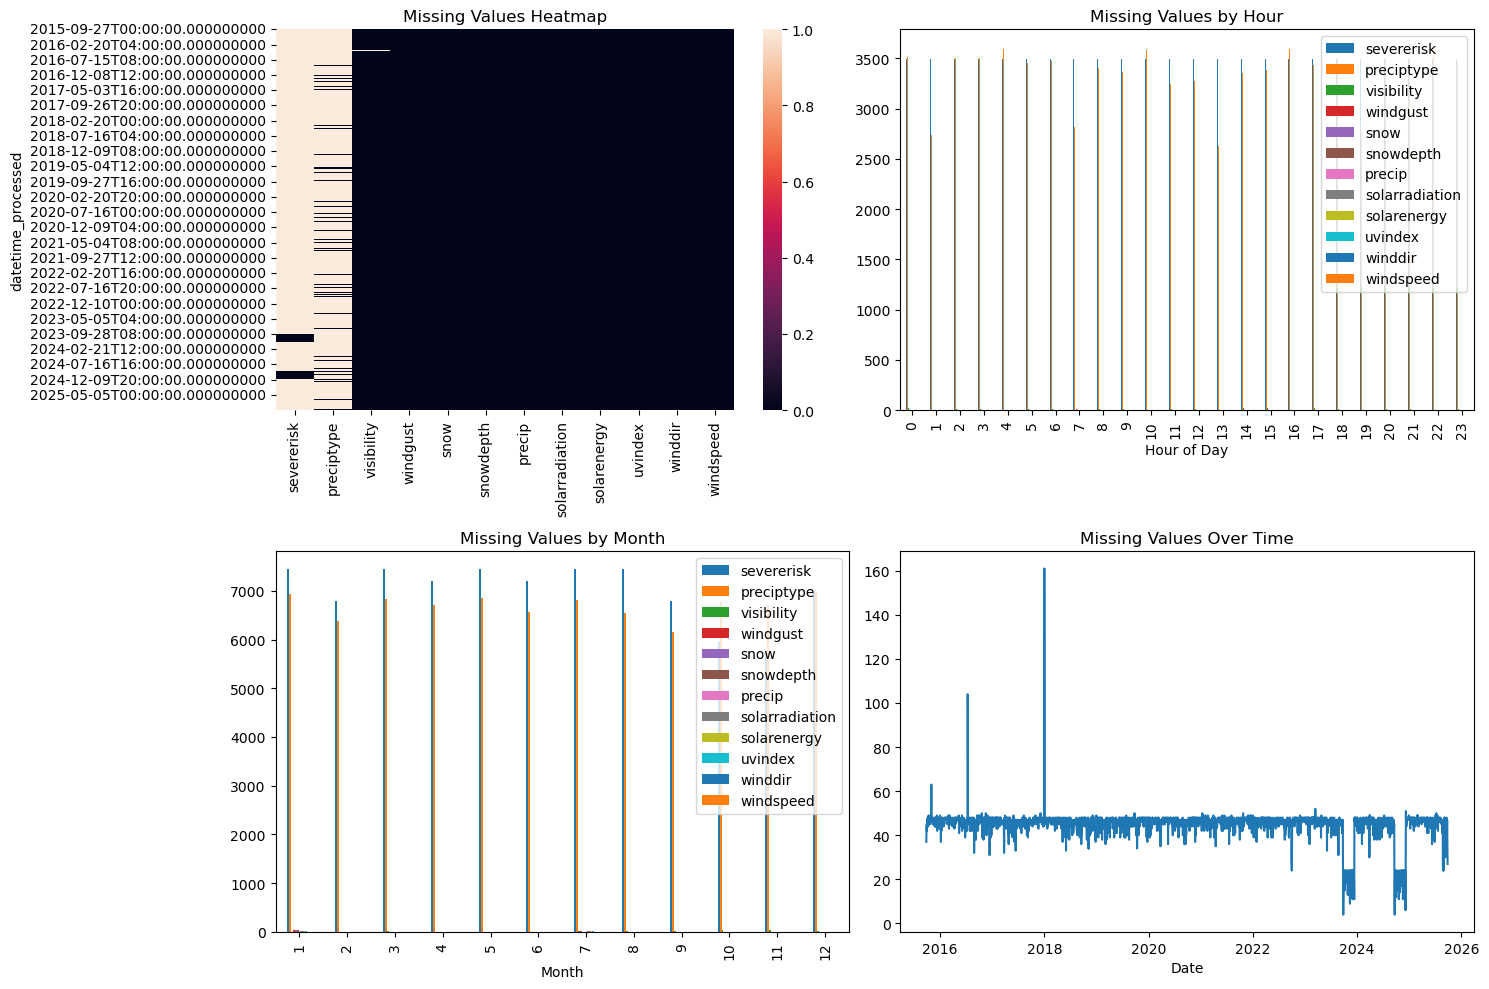


📊 DATA COMPLETENESS REPORT
Total records: 87,696
Complete records: 547
Completeness rate: 0.62%


In [8]:
# Comprehensive missing values analysis for hourly data
print("🔍 MISSING VALUES ANALYSIS")
print("=" * 35)

# Identify numeric columns (exclude temporal features we created)
temporal_cols = ['date', 'year', 'month', 'day', 'hour', 'day_of_week', 'day_of_year', 'week_of_year']
original_col = df_hourly.columns[0] if len(df_hourly.columns) > 0 else None
weather_cols = [col for col in df_hourly.columns if col not in temporal_cols and col != original_col]

print(f"🌤️ Weather columns: {len(weather_cols)}")
print(f"📅 Temporal columns: {len(temporal_cols)}")

# Missing values summary
missing_summary = pd.DataFrame({
    'Column': df_hourly.columns,
    'Missing_Count': df_hourly.isnull().sum(),
    'Missing_Percentage': (df_hourly.isnull().sum() / len(df_hourly)) * 100,
    'Data_Type': df_hourly.dtypes
})

missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

if len(missing_summary) > 0:
    print("⚠️ MISSING VALUES DETECTED:")
    print(missing_summary)
    
    # Visualize missing values
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Missing values heatmap
    missing_cols = missing_summary['Column'].tolist()
    if len(missing_cols) > 0:
        sns.heatmap(df_hourly[missing_cols].isnull(), cbar=True, ax=axes[0,0])
        axes[0,0].set_title('Missing Values Heatmap')
        
        # Missing values by hour
        hourly_missing = df_hourly.groupby('hour')[missing_cols].apply(lambda x: x.isnull().sum())
        hourly_missing.plot(kind='bar', ax=axes[0,1])
        axes[0,1].set_title('Missing Values by Hour')
        axes[0,1].set_xlabel('Hour of Day')
        
        # Missing values by month
        monthly_missing = df_hourly.groupby('month')[missing_cols].apply(lambda x: x.isnull().sum())
        monthly_missing.plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title('Missing Values by Month')
        axes[1,0].set_xlabel('Month')
        
        # Missing values timeline
        daily_missing = df_hourly.groupby(df_hourly.index.date)[missing_cols].apply(lambda x: x.isnull().sum().sum())
        daily_missing.plot(ax=axes[1,1])
        axes[1,1].set_title('Missing Values Over Time')
        axes[1,1].set_xlabel('Date')
    
    plt.tight_layout()
    plt.show()
else:
    print("✅ NO MISSING VALUES DETECTED!")

# Data completeness report
total_possible_records = len(df_hourly)
complete_records = df_hourly.dropna().shape[0]
completeness_rate = (complete_records / total_possible_records) * 100

print(f"\n📊 DATA COMPLETENESS REPORT")
print("=" * 30)
print(f"Total records: {total_possible_records:,}")
print(f"Complete records: {complete_records:,}")
print(f"Completeness rate: {completeness_rate:.2f}%")

In [10]:
# Handle missing values with time-aware interpolation
print("🔧 MISSING VALUES TREATMENT")
print("=" * 30)

if len(missing_summary) > 0:
    df_processed = df_hourly.copy()
    
    for col in missing_cols:
        missing_count = df_processed[col].isnull().sum()
        missing_pct = (missing_count / len(df_processed)) * 100
        
        print(f"\n🌡️ Processing column: {col}")
        print(f"   Missing: {missing_count} ({missing_pct:.2f}%)")
        
        # Check if column is numeric or categorical
        is_numeric = pd.api.types.is_numeric_dtype(df_processed[col])
        
        if missing_pct > 90:  # Mostly missing - drop or use mode/median
            if is_numeric:
                # For numeric columns with >90% missing, use median
                df_processed[col] = df_processed[col].fillna(df_processed[col].median())
                print(f"   ✅ Applied median fill (>90% missing)")
            else:
                # For categorical columns with >90% missing, use mode or 'unknown'
                mode_val = df_processed[col].mode()
                fill_val = mode_val.iloc[0] if len(mode_val) > 0 else 'unknown'
                df_processed[col] = df_processed[col].fillna(fill_val)
                print(f"   ✅ Applied mode/unknown fill (>90% missing)")
                
        elif missing_pct < 5:  # Small gaps - use interpolation
            if is_numeric:
                # Time-aware interpolation for small gaps
                df_processed[col] = df_processed[col].interpolate(method='time', limit=3)
                print(f"   ✅ Applied time interpolation (limit=3 hours)")
            else:
                # Forward fill for categorical
                df_processed[col] = df_processed[col].fillna(method='ffill', limit=3)
                print(f"   ✅ Applied forward fill (limit=3 hours)")
            
        elif missing_pct < 15:  # Medium gaps - use seasonal patterns
            if is_numeric:
                # Fill with hourly seasonal mean
                hourly_means = df_processed.groupby('hour')[col].mean()
                mask = df_processed[col].isnull()
                df_processed.loc[mask, col] = df_processed.loc[mask, 'hour'].map(hourly_means)
                print(f"   ✅ Applied hourly seasonal fill")
            else:
                # Fill with hourly seasonal mode
                hourly_modes = df_processed.groupby('hour')[col].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown')
                mask = df_processed[col].isnull()
                df_processed.loc[mask, col] = df_processed.loc[mask, 'hour'].map(hourly_modes)
                print(f"   ✅ Applied hourly seasonal mode fill")
                
        else:  # Large gaps - use forward/backward fill with seasonal backup
            # Forward fill limited to 6 hours, then seasonal
            df_processed[col] = df_processed[col].fillna(method='ffill', limit=6)
            
            if is_numeric:
                hourly_means = df_processed.groupby('hour')[col].mean()
                mask = df_processed[col].isnull()
                df_processed.loc[mask, col] = df_processed.loc[mask, 'hour'].map(hourly_means)
                print(f"   ✅ Applied forward fill + seasonal backup")
            else:
                hourly_modes = df_processed.groupby('hour')[col].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown')
                mask = df_processed[col].isnull()
                df_processed.loc[mask, col] = df_processed.loc[mask, 'hour'].map(hourly_modes)
                print(f"   ✅ Applied forward fill + seasonal mode backup")
    
    # Final check
    remaining_missing = df_processed.isnull().sum().sum()
    if remaining_missing > 0:
        print(f"\n⚠️ Still {remaining_missing} missing values - applying final cleanup...")
        df_processed = df_processed.fillna(method='ffill').fillna(method='bfill')
    
    print(f"\n✅ Missing values treatment completed!")
    print(f"Before: {df_hourly.isnull().sum().sum()} missing values")
    print(f"After: {df_processed.isnull().sum().sum()} missing values")
    
else:
    df_processed = df_hourly.copy()
    print("✅ No missing values to process!")

df_processed.head()

🔧 MISSING VALUES TREATMENT

🌡️ Processing column: severerisk
   Missing: 83856 (95.62%)
   ✅ Applied median fill (>90% missing)

🌡️ Processing column: preciptype
   Missing: 80193 (91.44%)
   ✅ Applied mode/unknown fill (>90% missing)

🌡️ Processing column: visibility
   Missing: 216 (0.25%)
   ✅ Applied time interpolation (limit=3 hours)

🌡️ Processing column: windgust
   Missing: 48 (0.05%)
   ✅ Applied time interpolation (limit=3 hours)

🌡️ Processing column: snow
   Missing: 41 (0.05%)
   ✅ Applied time interpolation (limit=3 hours)

🌡️ Processing column: snowdepth
   Missing: 41 (0.05%)
   ✅ Applied time interpolation (limit=3 hours)

🌡️ Processing column: precip
   Missing: 37 (0.04%)
   ✅ Applied time interpolation (limit=3 hours)

🌡️ Processing column: solarradiation
   Missing: 36 (0.04%)
   ✅ Applied time interpolation (limit=3 hours)

🌡️ Processing column: solarenergy
   Missing: 36 (0.04%)
   ✅ Applied time interpolation (limit=3 hours)

🌡️ Processing column: uvindex
   Mis

,name,address,resolvedAddress,latitude,longitude,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,source,date,year,month,day,hour,day_of_week,day_of_year,week_of_year
datetime_processed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-09-27 00:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T00:00:00,27.0,31.2,26.0,94.27,0.1,100,rain,0.0,0.0,6.5,5.4,106.6,1007.0,0.0,3.0,0.0,0.0,0.0,10.0,Rain,rain,obs,2015-09-27,2015,9,27,0,6,270,39
2015-09-27 01:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T01:00:00,26.5,26.5,25.9,96.32,0.0,0,rain,0.0,0.0,5.8,1.5,344.0,1008.0,1.3,8.9,0.0,0.0,0.0,10.0,Clear,clear-night,obs,2015-09-27,2015,9,27,1,6,270,39
2015-09-27 02:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T02:00:00,27.0,31.2,26.0,94.27,0.9,100,rain,0.0,0.0,8.3,0.9,20.2,1007.0,44.0,4.5,0.0,0.0,0.0,10.0,"Rain, Partially cloudy",rain,obs,2015-09-27,2015,9,27,2,6,270,39
2015-09-27 03:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T03:00:00,27.0,31.2,26.0,94.27,0.6,100,rain,0.0,0.0,8.6,0.9,360.0,1007.0,0.0,4.0,0.0,0.0,0.0,10.0,Rain,rain,obs,2015-09-27,2015,9,27,3,6,270,39
2015-09-27 04:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T04:00:00,26.3,26.3,25.7,96.87,0.0,0,rain,0.0,0.0,9.7,1.2,12.0,1007.7,0.5,8.6,0.0,0.0,0.0,10.0,Clear,clear-night,obs,2015-09-27,2015,9,27,4,6,270,39


## 4️⃣ Outlier Detection & Treatment

In [11]:
# Outlier detection for hourly weather data
print("🎯 OUTLIER DETECTION & TREATMENT")
print("=" * 35)

# Define weather-specific outlier thresholds
outlier_thresholds = {
    'temperature': (-20, 45),     # Celsius for Hanoi
    'humidity': (0, 100),         # Percentage
    'pressure': (900, 1050),      # hPa
    'wind_speed': (0, 50),        # m/s
    'precipitation': (0, 200),    # mm/h
    'visibility': (0, 50),        # km
    'solar_radiation': (0, 1500)  # W/m²
}

# Get numeric weather columns
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
weather_numeric_cols = [col for col in numeric_cols if col not in temporal_cols]

print(f"🌤️ Analyzing {len(weather_numeric_cols)} weather variables for outliers...")

outlier_stats = {}
outlier_indices = set()

for col in weather_numeric_cols:
    if col in df_processed.columns:
        # Method 1: IQR-based outlier detection
        Q1 = df_processed[col].quantile(0.25)
        Q3 = df_processed[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Method 2: Weather-specific thresholds (if available)
        weather_key = None
        for key in outlier_thresholds:
            if key in col.lower():
                weather_key = key
                break
        
        # Combine both methods
        outliers_iqr = (df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)
        
        if weather_key:
            w_lower, w_upper = outlier_thresholds[weather_key]
            outliers_weather = (df_processed[col] < w_lower) | (df_processed[col] > w_upper)
            outliers = outliers_iqr | outliers_weather
        else:
            outliers = outliers_iqr
        
        outlier_count = outliers.sum()
        outlier_indices.update(df_processed.index[outliers])
        
        outlier_stats[col] = {
            'count': outlier_count,
            'percentage': (outlier_count / len(df_processed)) * 100,
            'iqr_bounds': (lower_bound, upper_bound),
            'weather_bounds': outlier_thresholds.get(weather_key, 'N/A'),
            'outlier_values': df_processed.loc[outliers, col].describe()
        }
        
        print(f"\n🌡️ {col}:")
        print(f"   Outliers: {outlier_count} ({outlier_stats[col]['percentage']:.2f}%)")
        print(f"   IQR bounds: ({lower_bound:.2f}, {upper_bound:.2f})")
        if weather_key:
            print(f"   Weather bounds: {outlier_thresholds[weather_key]}")

print(f"\n📊 OUTLIER SUMMARY")
print("=" * 20)
print(f"Total unique outlier records: {len(outlier_indices)}")
print(f"Percentage of affected records: {(len(outlier_indices) / len(df_processed)) * 100:.2f}%")

🎯 OUTLIER DETECTION & TREATMENT
🌤️ Analyzing 20 weather variables for outliers...

🌡️ latitude:
   Outliers: 0 (0.00%)
   IQR bounds: (21.00, 21.00)

🌡️ longitude:
   Outliers: 0 (0.00%)
   IQR bounds: (105.85, 105.85)

🌡️ temp:
   Outliers: 102 (0.12%)
   IQR bounds: (9.00, 41.00)

🌡️ feelslike:
   Outliers: 0 (0.00%)
   IQR bounds: (1.50, 53.50)

🌡️ dew:
   Outliers: 1299 (1.48%)
   IQR bounds: (5.00, 37.00)

🌡️ humidity:
   Outliers: 345 (0.39%)
   IQR bounds: (30.70, 127.90)
   Weather bounds: (0, 100)

🌡️ precip:
   Outliers: 7158 (8.16%)
   IQR bounds: (0.00, 0.00)

🌡️ precipprob:
   Outliers: 7149 (8.15%)
   IQR bounds: (0.00, 0.00)

🌡️ snow:
   Outliers: 0 (0.00%)
   IQR bounds: (0.00, 0.00)

🌡️ snowdepth:
   Outliers: 0 (0.00%)
   IQR bounds: (0.00, 0.00)

🌡️ windgust:
   Outliers: 1106 (1.26%)
   IQR bounds: (-4.25, 37.75)

🌡️ windspeed:
   Outliers: 1301 (1.48%)
   IQR bounds: (-4.50, 21.90)

🌡️ winddir:
   Outliers: 0 (0.00%)
   IQR bounds: (-121.30, 375.50)

🌡️ sealevelpre

In [12]:
# Treat outliers with weather-aware methods
print("🔧 OUTLIER TREATMENT")
print("=" * 20)

df_clean = df_processed.copy()

if len(outlier_indices) > 0:
    print("Applying outlier treatment strategies...")
    
    for col in weather_numeric_cols:
        if col in df_clean.columns and col in outlier_stats:
            outlier_count = outlier_stats[col]['count']
            outlier_pct = outlier_stats[col]['percentage']
            
            if outlier_count > 0:
                print(f"\n🌡️ Treating {col} outliers ({outlier_count} values)")
                
                # Get outlier mask
                Q1 = df_clean[col].quantile(0.25)
                Q3 = df_clean[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                # Find weather-specific bounds
                weather_key = None
                for key in outlier_thresholds:
                    if key in col.lower():
                        weather_key = key
                        break
                
                outliers_iqr = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
                
                if weather_key:
                    w_lower, w_upper = outlier_thresholds[weather_key]
                    outliers_weather = (df_clean[col] < w_lower) | (df_clean[col] > w_upper)
                    outliers = outliers_iqr | outliers_weather
                else:
                    outliers = outliers_iqr
                
                if outlier_pct < 1:  # Less than 1% - use interpolation
                    df_clean.loc[outliers, col] = np.nan
                    df_clean[col] = df_clean[col].interpolate(method='time', limit=2)
                    print(f"   ✅ Applied time interpolation")
                    
                elif outlier_pct < 3:  # 1-3% - cap to boundaries
                    df_clean.loc[df_clean[col] < lower_bound, col] = lower_bound
                    df_clean.loc[df_clean[col] > upper_bound, col] = upper_bound
                    print(f"   ✅ Applied boundary capping")
                    
                else:  # >3% - use robust statistics
                    # Replace with hourly median for that specific hour
                    hourly_medians = df_clean.groupby('hour')[col].median()
                    for idx in df_clean.index[outliers]:
                        hour = df_clean.loc[idx, 'hour']
                        df_clean.loc[idx, col] = hourly_medians[hour]
                    print(f"   ✅ Applied hourly median replacement")
    
    # Fill any remaining NaN values
    remaining_nan = df_clean.isnull().sum().sum()
    if remaining_nan > 0:
        df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')
        print(f"\n🔧 Filled {remaining_nan} remaining NaN values")
    
    print(f"\n✅ Outlier treatment completed!")
    
else:
    print("✅ No outliers detected - data looks clean!")

# Validation
print(f"\n📊 FINAL DATA VALIDATION")
print("=" * 25)
print(f"Shape: {df_clean.shape}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")
print(f"Duplicate records: {df_clean.duplicated().sum()}")

df_clean.head()

🔧 OUTLIER TREATMENT
Applying outlier treatment strategies...

🌡️ Treating temp outliers (102 values)
   ✅ Applied time interpolation

🌡️ Treating dew outliers (1299 values)
   ✅ Applied boundary capping

🌡️ Treating humidity outliers (345 values)
   ✅ Applied time interpolation

🌡️ Treating precip outliers (7158 values)
   ✅ Applied hourly median replacement

🌡️ Treating precipprob outliers (7149 values)
   ✅ Applied hourly median replacement

🌡️ Treating precipprob outliers (7149 values)
   ✅ Applied hourly median replacement

🌡️ Treating windgust outliers (1106 values)
   ✅ Applied boundary capping

🌡️ Treating windspeed outliers (1301 values)
   ✅ Applied boundary capping

🌡️ Treating sealevelpressure outliers (35 values)
   ✅ Applied time interpolation

🌡️ Treating visibility outliers (4173 values)
   ✅ Applied hourly median replacement

🌡️ Treating windgust outliers (1106 values)
   ✅ Applied boundary capping

🌡️ Treating windspeed outliers (1301 values)
   ✅ Applied boundary capp

,name,address,resolvedAddress,latitude,longitude,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,source,date,year,month,day,hour,day_of_week,day_of_year,week_of_year
datetime_processed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-09-27 00:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T00:00:00,27.0,31.2,26.0,94.27,0.0,0,rain,0.0,0.0,6.5,5.4,106.6,1007.0,0.0,3.0,0.0,0.0,0.0,10.0,Rain,rain,obs,2015-09-27,2015,9,27,0,6,270,39
2015-09-27 01:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T01:00:00,26.5,26.5,25.9,96.32,0.0,0,rain,0.0,0.0,5.8,1.5,344.0,1008.0,1.3,8.9,0.0,0.0,0.0,10.0,Clear,clear-night,obs,2015-09-27,2015,9,27,1,6,270,39
2015-09-27 02:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T02:00:00,27.0,31.2,26.0,94.27,0.0,0,rain,0.0,0.0,8.3,0.9,20.2,1007.0,44.0,4.5,0.0,0.0,0.0,10.0,"Rain, Partially cloudy",rain,obs,2015-09-27,2015,9,27,2,6,270,39
2015-09-27 03:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T03:00:00,27.0,31.2,26.0,94.27,0.0,0,rain,0.0,0.0,8.6,0.9,360.0,1007.0,0.0,4.0,0.0,0.0,0.0,10.0,Rain,rain,obs,2015-09-27,2015,9,27,3,6,270,39
2015-09-27 04:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T04:00:00,26.3,26.3,25.7,96.87,0.0,0,rain,0.0,0.0,9.7,1.2,12.0,1007.7,0.5,8.6,0.0,0.0,0.0,10.0,Clear,clear-night,obs,2015-09-27,2015,9,27,4,6,270,39


## 5️⃣ Data Quality Validation & Export

In [13]:
# Final data quality validation
print("✅ FINAL DATA QUALITY REPORT")
print("=" * 30)

# Basic statistics
print("📊 PROCESSED DATASET STATISTICS")
print("-" * 35)
print(f"Total records: {len(df_clean):,}")
print(f"Date range: {df_clean.index.min()} to {df_clean.index.max()}")
print(f"Duration: {df_clean.index.max() - df_clean.index.min()}")
print(f"Columns: {len(df_clean.columns)}")

# Data quality metrics
print(f"\n🎯 DATA QUALITY METRICS")
print("-" * 25)
print(f"Completeness: {((len(df_clean) - df_clean.isnull().sum().sum()) / (len(df_clean) * len(df_clean.columns))) * 100:.2f}%")
print(f"Missing values: {df_clean.isnull().sum().sum()}")
print(f"Duplicate records: {df_clean.duplicated().sum()}")

# Time series validation
time_gaps = df_clean.index.to_series().diff()
expected_freq = pd.Timedelta('1H')
irregular_gaps = time_gaps[time_gaps != expected_freq]

print(f"\n⏰ TIME SERIES VALIDATION")
print("-" * 25)
print(f"Expected frequency: 1 hour")
print(f"Irregular time gaps: {len(irregular_gaps)}")
if len(irregular_gaps) > 0:
    print(f"Gap sizes: {irregular_gaps.describe()}")

# Weather variables summary
print(f"\n🌤️ WEATHER VARIABLES SUMMARY")
print("-" * 30)
for col in weather_numeric_cols:
    if col in df_clean.columns:
        stats = df_clean[col].describe()
        print(f"{col:15} | Range: [{stats['min']:.2f}, {stats['max']:.2f}] | Mean: {stats['mean']:.2f} | Std: {stats['std']:.2f}")

# Export processed data
os.makedirs(PROCESSED_PATH, exist_ok=True)
output_file = os.path.join(PROCESSED_PATH, 'hanoi_weather_hourly_processed.csv')

# Reset index to include datetime as column for export
df_export = df_clean.reset_index()
df_export.to_csv(output_file, index=False)

print(f"\n💾 DATA EXPORT")
print("-" * 15)
print(f"✅ Processed data saved to: {output_file}")
print(f"📊 Shape: {df_export.shape}")
print(f"💽 File size: {os.path.getsize(output_file) / 1024 / 1024:.2f} MB")

print(f"\n🎉 HOURLY DATA PROCESSING COMPLETED!")
print("=" * 40)
print("✅ Ready for feature engineering phase!")

df_clean.head()

✅ FINAL DATA QUALITY REPORT
📊 PROCESSED DATASET STATISTICS
-----------------------------------
Total records: 87,696
Date range: 2015-09-27 00:00:00 to 2025-09-27 23:00:00
Duration: 3653 days 23:00:00
Columns: 36

🎯 DATA QUALITY METRICS
-------------------------
Completeness: 2.78%
Missing values: 0
Duplicate records: 0

⏰ TIME SERIES VALIDATION
-------------------------
Expected frequency: 1 hour
Irregular time gaps: 1
Gap sizes: count      0
mean     NaT
std      NaT
min      NaT
25%      NaT
50%      NaT
75%      NaT
max      NaT
Name: datetime_processed, dtype: object

🌤️ WEATHER VARIABLES SUMMARY
------------------------------
latitude        | Range: [21.00, 21.00] | Mean: 21.00 | Std: 0.00
longitude       | Range: [105.85, 105.85] | Mean: 105.85 | Std: 0.00
temp            | Range: [9.00, 41.00] | Mean: 24.84 | Std: 5.58
feelslike       | Range: [2.10, 52.50] | Mean: 27.31 | Std: 8.48
dew             | Range: [5.00, 31.00] | Mean: 20.46 | Std: 5.87
humidity        | Range: [30.7

,name,address,resolvedAddress,latitude,longitude,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,source,date,year,month,day,hour,day_of_week,day_of_year,week_of_year
datetime_processed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-09-27 00:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T00:00:00,27.0,31.2,26.0,94.27,0.0,0,rain,0.0,0.0,6.5,5.4,106.6,1007.0,0.0,3.0,0.0,0.0,0.0,10.0,Rain,rain,obs,2015-09-27,2015,9,27,0,6,270,39
2015-09-27 01:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T01:00:00,26.5,26.5,25.9,96.32,0.0,0,rain,0.0,0.0,5.8,1.5,344.0,1008.0,1.3,8.9,0.0,0.0,0.0,10.0,Clear,clear-night,obs,2015-09-27,2015,9,27,1,6,270,39
2015-09-27 02:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T02:00:00,27.0,31.2,26.0,94.27,0.0,0,rain,0.0,0.0,8.3,0.9,20.2,1007.0,44.0,4.5,0.0,0.0,0.0,10.0,"Rain, Partially cloudy",rain,obs,2015-09-27,2015,9,27,2,6,270,39
2015-09-27 03:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T03:00:00,27.0,31.2,26.0,94.27,0.0,0,rain,0.0,0.0,8.6,0.9,360.0,1007.0,0.0,4.0,0.0,0.0,0.0,10.0,Rain,rain,obs,2015-09-27,2015,9,27,3,6,270,39
2015-09-27 04:00:00,Hanoi,Hanoi,Hanoi,21,105.85,2015-09-27T04:00:00,26.3,26.3,25.7,96.87,0.0,0,rain,0.0,0.0,9.7,1.2,12.0,1007.7,0.5,8.6,0.0,0.0,0.0,10.0,Clear,clear-night,obs,2015-09-27,2015,9,27,4,6,270,39
